### Methodolody

What I want to do is look at the practice sessions for each race and look at the long runs of each car to find the tyre deg, then apply that and work through lap by lap for the race.

Then obviously the pit stops are whatever has the lowest total race time.

This could be put futher into even looking at other cars and not pitting into traffic, but then we start getting quite complicated.

Really just want to do this as a proof of concept, then look into ML models. May come back and improve to compare to ML models.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


## Collect data into df

In [2]:
def create_dataframe():
	# initialize db connection and session
	db_engine, db_session = init_db()

	# query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# create dataframe
	df = pd.DataFrame(data)


	return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())




['year', 'round', 'circuit_name', 'driver_name', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


### Normalise/correct laps for fuel load

Start with 110kg - to 0kg - assume constant over race
0.03 sec/kg (lap)

https://www.stem.org.uk/resources/elibrary/resource/25407/formula-one-race-strategy#&gid=undefined&pid=1

        year  round
238345  2023     22
236243  2023     21
234454  2023     20
231741  2023     19
230212  2023     18
228521  2023     17
226701  2023     16
224510  2023     15
222291  2023     14
219484  2023     13
{np.int64(1): array([-3.49750029e-04,  1.93789855e-02,  1.08304432e+00]), np.int64(2): array([-0.00389202,  0.29160099, -2.52762717]), np.int64(3): array([-0.00206057,  0.16304527, -1.11933591])}


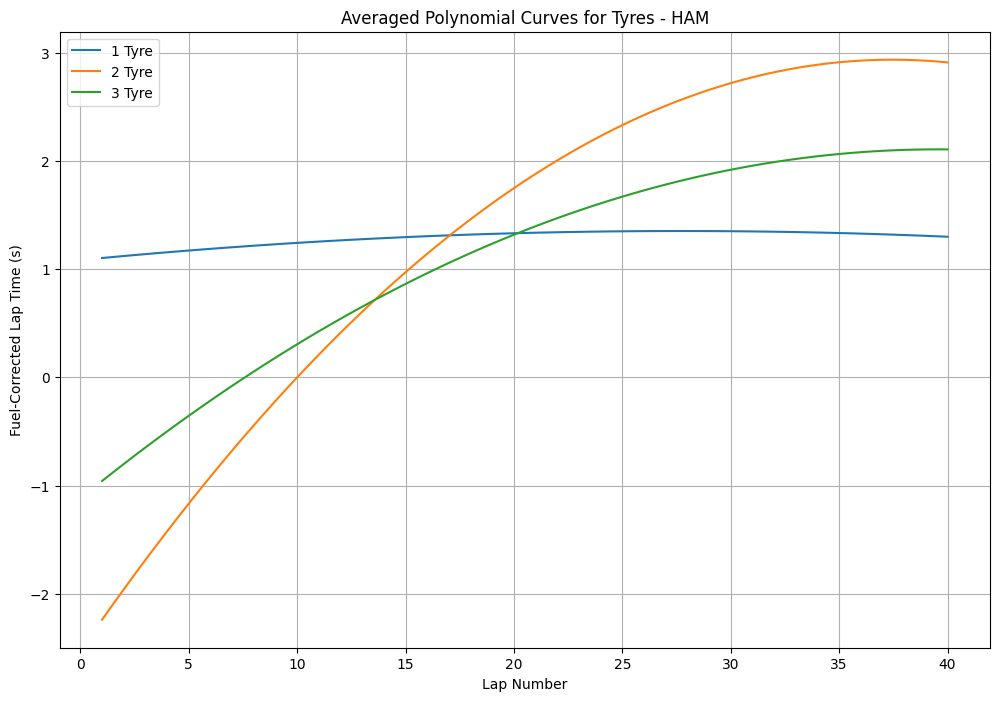

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Adjust lap times in a race for the effect of fuel weight
	race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
	max_laps = race_df['lap_num'].max()
	race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
	race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
	race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
	return race_df

def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df

def get_last_10_races_from_round(df, year, round_):
	# Get the last 10 unique races starting from a given year and round
	df_unique = df.drop_duplicates(subset=['year', 'round'])
	filtered_df = df_unique[
		(df_unique['year'] < year) | 
		((df_unique['year'] == year) & (df_unique['round'] <= round_))
	]
	df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])
	last_10_races = df_sorted[['year', 'round']].head(10)
	return last_10_races

def analyze_and_average_polynomials(df, driver, current_year, current_round):
	# Get the last 10 races starting from the current race
	last_10_races = get_last_10_races_from_round(df, current_year, current_round)
	print(last_10_races)
	
	# Store polynomial coefficients for each tyre type across races
	tyre_poly_coeffs = {tyre: [] for tyre in df['tyre'].unique()}
	
	# Loop through each race in the last 10 races
	for _, race in last_10_races.iterrows():
		year = race['year']
		round_ = race['round']
		
		# Filter the DataFrame for the specific race and driver
		race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver)].copy()
		
		# Correct for fuel effect
		race_df = correct_fuel_effect(race_df, year, round_)
		
		# Normalize lap times based on the fastest lap and filter out outliers
		fastest_lap_time = race_df['fuel_corrected_lap_time'].min()
		race_df = race_df[race_df['fuel_corrected_lap_time'] <= 1.07 * fastest_lap_time]  # Filter out lap times more than 7% slower
		
		# Calculate the difference from the fastest lap for each lap
		race_df['time_diff'] = race_df['fuel_corrected_lap_time'] - fastest_lap_time
		
		# Assign stint numbers
		race_df = assign_stint_numbers(race_df)
		
		# Loop over each tyre type and perform polynomial regression for each stint
		for tyre in race_df['tyre'].unique():
			tyre_data = race_df[race_df['tyre'] == tyre]
			
			# Loop through each stint for the given tyre type
			for stint in tyre_data['stint'].unique():
				stint_data = tyre_data[tyre_data['stint'] == stint]
				x = stint_data['lap_num']
				y = stint_data['time_diff']
				
				# Polynomial regression (2nd degree)
				if len(x) > 2:
					poly_coeffs = np.polyfit(x, y, 2)
					tyre_poly_coeffs[tyre].append(poly_coeffs)
	
	# Average the polynomial coefficients for each tyre type across all races
	averaged_poly_coeffs = {}
	for tyre, poly_coeffs_list in tyre_poly_coeffs.items():
		if poly_coeffs_list:
			avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
			averaged_poly_coeffs[tyre] = avg_poly_coeffs
	print(averaged_poly_coeffs)
	# Plot the averaged polynomial curves for each tyre type
	plt.figure(figsize=(12, 8))
	colors = plt.cm.tab10.colors  # Use a color map for distinct colors
	
	for i, (tyre, coeffs) in enumerate(averaged_poly_coeffs.items()):
		# Create a polynomial function from the averaged coefficients
		poly_fit = np.poly1d(coeffs)
		
		# Create an x-axis range for plotting
		x_range = np.linspace(1, 40, 100)  # Adjust lap range as needed
		y_fit = poly_fit(x_range)
		
		plt.plot(x_range, y_fit, linestyle='-', color=colors[i % len(colors)], label=f"{tyre} Tyre")
	
	plt.title(f"Averaged Polynomial Curves for Tyres - {driver}")
	plt.xlabel("Lap Number")
	plt.ylabel("Fuel-Corrected Lap Time (s)")
	plt.legend()
	plt.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Analyze and average polynomials for the last 10 races
analyze_and_average_polynomials(df, driver='HAM', current_year=2023, current_round=22)


Averaged Polynomial Coefficients:
Tyre: 1, Coefficients: [ 2.58374681e-02 -2.20600095e+00  4.77309496e+01]
Tyre: 2, Coefficients: [ 1.05192505e-02 -4.73861238e-01  1.05655965e+01]
Tyre: 3, Coefficients: [-6.49588539e-04  9.42555361e-02 -1.80615124e+00]
Tyre: 4, Coefficients: [-0.00364012  0.23226268 -0.19735611]
Tyre: 5, Coefficients: None
Tyre: -1, Coefficients: None


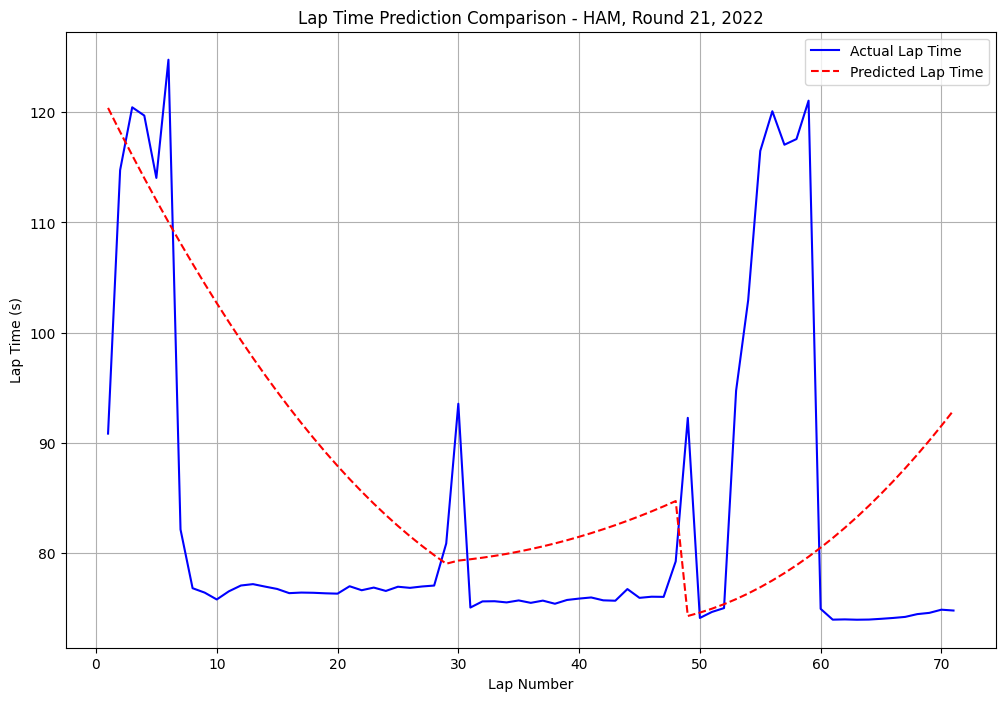

Total Actual Race Time: 5915.573 seconds
Total Predicted Race Time: 6222.323 seconds
Difference: 306.750 seconds


,year,round,circuit_name,driver_name,driver_short,lap_num,lap_time,tyre,tyre_laps,pit,session_type,fuel_weight,fuel_correction,predicted_lap_time,time_difference
189633,2022,21,São Paulo,Lewis Hamilton,HAM,1,90.833,1,1,False,Race,110.000000,3.300000,120.389786,29.556786
189634,2022,21,São Paulo,Lewis Hamilton,HAM,2,114.748,1,2,False,Race,108.450704,3.253521,118.214819,3.466819
189635,2022,21,São Paulo,Lewis Hamilton,HAM,3,120.447,1,3,False,Race,106.901408,3.207042,116.091526,-4.355474
189636,2022,21,São Paulo,Lewis Hamilton,HAM,4,119.697,1,4,False,Race,105.352113,3.160563,114.019909,-5.677091
189637,2022,21,São Paulo,Lewis Hamilton,HAM,5,114.039,1,5,False,Race,103.802817,3.114085,111.999966,-2.039034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189699,2022,21,São Paulo,Lewis Hamilton,HAM,67,74.199,1,25,False,Race,7.746479,0.232394,87.684674,13.485674
189700,2022,21,São Paulo,Lewis Hamilton,HAM,68,74.450,1,26,False,Race,6.197183,0.185915,88.920253,14.470253
189701,2022,21,São Paulo,Lewis Hamilton,HAM,69,74.564,1,27,False,Race,4.647887,0.139437,90.207506,15.643506
189702,2022,21,São Paulo,Lewis Hamilton,HAM,70,74.853,1,28,False,Race,3.098592,0.092958,91.546434,16.693434


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def correct_fuel_effect_for_tyre_model(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
    """
    Removes the fuel effect to normalize lap times for tire model building.
    """
    race_df = df[
        (df['year'] == year) &
        (df['round'] == race_round) &
        (df['session_type'] == "Race")
    ].copy()

    max_laps = race_df['lap_num'].max()
    race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
    race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
    race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
    return race_df

def add_fuel_effect_for_prediction(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
    """
    Adds the fuel effect for predicting lap times starting from a low-fuel baseline.
    """
    race_df = df[
        (df['year'] == year) &
        (df['round'] == race_round) &
        (df['session_type'] == "Race")
    ].copy()

    max_laps = race_df['lap_num'].max()
    race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
    race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
    return race_df

def predict_and_compare(df, driver, current_year, current_round, prediction_year, prediction_round):
    # Step 1: Get averaged polynomial coefficients for tyres
    last_10_races = get_last_10_races_from_round(df, current_year, current_round)
    tyre_poly_coeffs = {tyre: [] for tyre in df['tyre'].unique()}

    for _, race in last_10_races.iterrows():
        year = race['year']
        round_ = race['round']
        race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver)].copy()

        if race_df.empty:
            print(f"No data for {driver} in year {year}, round {round_}. Skipping.")
            continue

        race_df = correct_fuel_effect_for_tyre_model(race_df, year, round_)
        race_df = race_df[race_df['fuel_corrected_lap_time'] <= 1.07 * race_df['fuel_corrected_lap_time'].min()]
        race_df = assign_stint_numbers(race_df)

        for tyre in race_df['tyre'].unique():
            tyre_data = race_df[race_df['tyre'] == tyre]
            for stint in tyre_data['stint'].unique():
                stint_data = tyre_data[tyre_data['stint'] == stint]
                x = stint_data['lap_num']
                y = stint_data['fuel_corrected_lap_time'] - stint_data['fuel_corrected_lap_time'].min()
                if len(x) > 2:
                    poly_coeffs = np.polyfit(x, y, 2)
                    tyre_poly_coeffs[tyre].append(poly_coeffs)

    averaged_poly_coeffs = {
        tyre: np.mean(coeffs, axis=0) if coeffs else None
        for tyre, coeffs in tyre_poly_coeffs.items()
    }

    # Debug: Print averaged coefficients
    print("Averaged Polynomial Coefficients:")
    for tyre, coeffs in averaged_poly_coeffs.items():
        print(f"Tyre: {tyre}, Coefficients: {coeffs}")

    # Step 2: Get the driver's best qualifying time as the baseline
    qualifying_df = df[
        (df['year'] == prediction_year) &
        (df['round'] == prediction_round) &
        (df['driver_short'] == driver) &
        (df['session_type'] == "Qualifying")
    ]
    if qualifying_df.empty:
        print(f"No qualifying data for {driver} in year {prediction_year}, round {prediction_round}. Cannot predict.")
        return

    baseline_time = qualifying_df['lap_time'].min()

    # Step 3: Predict lap times using tyre models and fuel effects
    prediction_df = add_fuel_effect_for_prediction(df, prediction_year, prediction_round)
    prediction_df['predicted_lap_time'] = baseline_time
    prediction_df = (prediction_df[(prediction_df['driver_short'] == driver)])

    for index, row in prediction_df.iterrows():
        tyre = row['tyre']
        if tyre in averaged_poly_coeffs and averaged_poly_coeffs[tyre] is not None:
            lap_num = row['lap_num']
            fuel_effect = row['fuel_correction']
            tyre_model_effect = np.poly1d(averaged_poly_coeffs[tyre])(lap_num)
            prediction_df.at[index, 'predicted_lap_time'] += tyre_model_effect + fuel_effect

    # Step 4: Plot predictions vs actual lap times
    if prediction_df['predicted_lap_time'].notna().any():
        plt.figure(figsize=(12, 8))
        plt.plot(prediction_df['lap_num'], prediction_df['lap_time'], label="Actual Lap Time", color="blue")
        plt.plot(prediction_df['lap_num'], prediction_df['predicted_lap_time'], label="Predicted Lap Time", linestyle='--', color="red")
        plt.title(f"Lap Time Prediction Comparison - {driver}, Round {prediction_round}, {prediction_year}")
        plt.xlabel("Lap Number")
        plt.ylabel("Lap Time (s)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No predictions were generated to plot.")

    # Step 5: Calculate prediction accuracy
    prediction_df['time_difference'] = prediction_df['predicted_lap_time'] - prediction_df['lap_time']
    if 'predicted_lap_time' in prediction_df.columns and 'lap_time' in prediction_df.columns:
        total_actual_time = prediction_df['lap_time'].sum()
        total_predicted_time = prediction_df['predicted_lap_time'].sum()
        print(f"Total Actual Race Time: {total_actual_time:.3f} seconds")
        print(f"Total Predicted Race Time: {total_predicted_time:.3f} seconds")
        print(f"Difference: {total_predicted_time - total_actual_time:.3f} seconds")

    return prediction_df



prediction_df = predict_and_compare(
    df=df,                     # Your dataset
    driver='HAM',              # Driver's short code (e.g., 'HAM' for Lewis Hamilton)
    current_year=2022,         # Current year of the analysis
    current_round=20,          # Current round of the analysis
    prediction_year=2022,      # Year of the race to predict
    prediction_round=21        # Round of the race to predict
)


prediction_df